<a href="https://colab.research.google.com/github/VictorMadu/Coursera-Deep-Learning-Specialization-Course/blob/master/How-to-win-a-data-science-competition/Final-Project/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount G-drive

## Download the dataset we need

# EDA

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline 


In [ ]:
DATA_FOLDER = '../input/'

# Load all files available
sales_train     = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

# Translations from https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/133809
items_en = pd.read_csv(os.path.join(DATA_FOLDER, 'compressed_items_en.csv.zip'))
item_categories_en = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories_en.csv'))
shops_en           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops_en.csv'))

## sales_train
Describe's, heads and outliers

In [ ]:
sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [ ]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


The outliers will be removed in feature engineering.

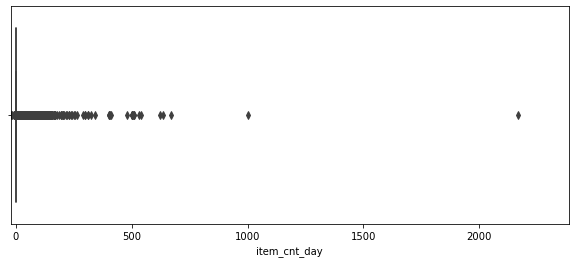

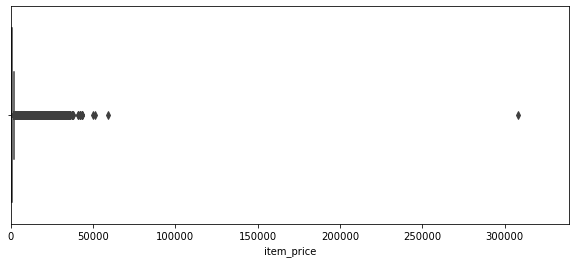

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_cnt_day.min(), sales_train.item_cnt_day.max()*1.1)
sns.boxplot(x=sales_train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.1)
sns.boxplot(x=sales_train.item_price)

The rest of features will considered as categorical features (date_block_num, shop_id and item_id), so we'll need transform in encodings (mean encodings with target item_cnt_month)


## test

In [ ]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


We can see that items and shops in test are not the same that in sales, so we need to generate a training and validation data with test values in order to obtain information about this combinations. Furthermore there are 210284 pairs different.

In [ ]:
# Find differences between train and test
sales_train[['shop_id', 'item_id']].merge(test[['shop_id', 'item_id']],
                        indicator = True, how='left').loc[lambda x : x['_merge']!='both']. \
                        drop_duplicates(keep=False)

,shop_id,item_id,_merge
3,25,2554,left_only
6,25,2565,left_only
55,25,2522,left_only
73,25,2845,left_only
132,25,2149,left_only
...,...,...,...
2935670,25,7904,left_only
2935802,25,7583,left_only
2935804,25,7610,left_only
2935811,25,7635,left_only


In [ ]:
# Find differences between test and train
test[['shop_id', 'item_id']].merge(sales_train[['shop_id', 'item_id']],
                        indicator = True, how='left').loc[lambda x : x['_merge']!='both']. \
                        drop_duplicates(keep=False)

,shop_id,item_id,_merge
13,5,5320,left_only
24,5,5268,left_only
96,5,5003,left_only
342,5,4874,left_only
414,5,5002,left_only
...,...,...,...
1327197,45,9500,left_only
1327198,45,16007,left_only
1327212,45,18027,left_only
1327222,45,16188,left_only


## items and items_categories

In [ ]:
items.describe().T

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


In [ ]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


For some people and me, easier way, :-). Any way there is something at first characters that we could use as a categorical feature.

In [ ]:
items_en.head(20)

,item_name,item_id,item_category_id
0,! POWER IN glamor (PLAST.) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** In the glory (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40
5,*** NEW American Graffiti (UNI) D,5,40
6,*** shot on goal (UNI) D,6,40
7,*** shot on goal-2 (UNI) D,7,40
8,*** Tea with Mussolini D,8,40
9,*** SHUGARLENDSKY EXPRESS (UNI) D,9,40


In [ ]:
meta_item = items_en['item_name'].str.split(' ').map(lambda x: x[0])
meta_item.drop_duplicates().head()

0       !
2     ***
10      *
15     //
18      /
Name: item_name, dtype: object

In [ ]:
# Russian version, replace and search
def extract(x):
    m = re.match(r'^([!\*\/]+).*$', x)
    if m:
        return m.group(1)
    else:
        return ''

def clean(x):
    m = re.match(r'^[!\*\/]+(.*$)', x)
    if m:
        return m.group(1)
    else:
        return x

    
meta_item = items['item_name'].map(extract)
items['meta_item'] = meta_item
items['item_name'] = items['item_name'].map(clean)

In [ ]:
items['item_name'].map(extract)

In [ ]:
items

,item_name,item_id,item_category_id,meta_item
0,ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,!
1,ABBYY FineReader 12 Professional Edition Full ...,1,76,!
2,В ЛУЧАХ СЛАВЫ (UNV) D,2,40,***
3,ГОЛУБАЯ ВОЛНА (Univ) D,3,40,***
4,КОРОБКА (СТЕКЛО) D,4,40,***
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,
22168,Яйцо для Little Inu,22168,62,


In [ ]:
item_categories_en.describe().T

,count,mean,std,min,25%,50%,75%,max
item_category_id,84.0,41.5,24.392622,0.0,20.75,41.5,62.25,83.0


In [ ]:
item_categories_en.head()

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


Clearly we can get more information about the item splitting the data in item_category_name:

In [ ]:
item_categories_en['meta'] = item_categories_en['item_category_name'].str.split(' ').map(lambda x: x[0])
item_categories_en.meta.drop_duplicates().head()

0              PC
1     Accessories
8         Tickets
9        Delivery
10           Game
Name: meta, dtype: object

In [ ]:
# Russian version
item_categories['meta_category'] = item_categories['item_category_name'].str.split(' ').map(lambda x: x[0])
item_categories.meta_category.drop_duplicates().head()

0             PC
1     Аксессуары
8         Билеты
9       Доставка
10       Игровые
Name: meta_category, dtype: object

In [ ]:
item_categories.head()

,item_category_name,item_category_id,meta_category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


## shops

In [ ]:
shops.describe().T

,count,mean,std,min,25%,50%,75%,max
shop_id,60.0,29.5,17.464249,0.0,14.75,29.5,44.25,59.0


In [ ]:
shops_en.head(20)

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 Franc",0
1,"! Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
4,"Volzhsky mall ""Volga Mall""",4
5,"Vologda SEC ""Marmalade""",5
6,"Voronezh (Plekhanovskaya, 13)",6
7,"Voronezh TRC ""Maksimir""",7
8,"Voronezh TRC City-Park ""City""",8
9,Itinerant trade,9


We can see that first characters are cities, but there are cities with '!', so it is possible to obtain city and and indicator.

In [ ]:
shops_en.shop_name.str[0].drop_duplicates()

0     !
2     A
3     B
4     V
9     I
10    Z
12    S
13    K
20    M
34    N
38    O
39    R
48    T
52    U
55    D
56    C
57    Y
Name: shop_name, dtype: object

In [ ]:
# Russian version
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['flag_city'] = (shops['city'].str[0] == '!')*1
shops['city'] = shops['city'].str.replace('!','')

In [ ]:
shops.head()

,shop_name,shop_id,city,flag_city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,1
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,1
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,0


In [ ]:
# Save new features
items.to_pickle(os.path.join(DATA_FOLDER, 'items.pkl'))
item_categories.to_pickle(os.path.join(DATA_FOLDER, 'item_categories.pkl'))
shops.to_pickle(os.path.join(DATA_FOLDER, 'shops.pkl'))                